# Analisis para Latinoamerica

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FixedLocator, MultipleLocator
import locale
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8');

# Dataset
Dataset tomados de Center for Systems Science and Engineering (CSSE) at Johns Hopkins University

In [2]:
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
country_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv')

In [3]:
# renaming the df column names to lowercase
country_df.columns = map(str.lower, country_df.columns)
confirmed_df.columns = map(str.lower, confirmed_df.columns)
death_df.columns = map(str.lower, death_df.columns)
recovered_df.columns = map(str.lower, recovered_df.columns)

# changing province/state to state and country/region to country
confirmed_df = confirmed_df.rename(columns={'province/state': 'state', 'country/region': 'country'})
recovered_df = recovered_df.rename(columns={'province/state': 'state', 'country/region': 'country'})
death_df = death_df.rename(columns={'province/state': 'state', 'country/region': 'country'})
country_df = country_df.rename(columns={'country_region': 'country'})

## Función nuevos
Se usa para convertir los datos que vienen distribuidos en filas por paises a columnas

In [4]:
def nuevos(country, df):
    temp = df[df['country'] == country ].iloc[:,4:]
    temp = (temp - temp.shift(axis=1)).T
    temp.fillna(0, inplace=True)
    return temp.values

## Función paises
Se usa pra ...

In [5]:
def paises(country):
    df = pd.DataFrame() 
    df['date'] = pd.to_datetime(confirmed_df.iloc[:,4:].columns)
    df['casos'] = confirmed_df[confirmed_df['country'] == country ].iloc[:,4:].T.values
    df['casos_nuevos'] = nuevos(country=country, df=confirmed_df)

    df['muertes'] = death_df[death_df['country'] == country ].iloc[:,4:].T.values
    df['muertes_nuevas'] = nuevos(country=country, df=death_df)

    df['recuperados'] = recovered_df[recovered_df['country'] == country ].iloc[:,4:].T.values
    df['recuperados_nuevos'] = nuevos(country=country, df=recovered_df)

    df['activos'] = df['casos'] - df['muertes'] - df['recuperados']
    df['muertes %'] = round(( (df['muertes'] - df['muertes'].shift(1)) / df['muertes'].shift(1))*100,2)
    df['muertes nuevas %'] = round(( (df['muertes_nuevas'] - df['muertes_nuevas'].shift(1)) / df['muertes_nuevas'].shift(1))*100,2)
    df['casos %'] = round(( (df['casos'] - df['casos'].shift(1)) / df['casos'].shift(1))*100,2)
    df['casos nuevos %'] = round(( (df['casos_nuevos'] - df['casos_nuevos'].shift(1)) / df['casos_nuevos']
    .shift(1))*100,2)
    df['pais'] = country
    df.fillna(0,inplace=True)
    return df[df['casos']>0].reset_index().copy()

In [6]:
df_COL = paises('Colombia')
df_ARG = paises('Argentina')
df_BRA = paises('Brazil')
df_CHI = paises('Chile')
df_PER = paises('Peru')
df_PAR = paises('Paraguay')
df_URU = paises('Uruguay')
df_VEN = paises('Venezuela')
df_BOL = paises('Bolivia')
df_MEX = paises('Mexico')
df_ITA = paises('Italy')
df_ES = paises('Spain')

## Funcion rollingCases
Se usa para obtener el promedio movil de la serie de tiempo por siete días

In [7]:
def rollingCases(df, cases, columnaConPromedio, columnaSinPromedio):
    df[columnaConPromedio] = df[columnaSinPromedio].rolling(7, win_type='gaussian').mean(std=3)
    # Se toma el indice desde que los casos superan X cantidad
    first_value = df[ df[columnaConPromedio] >= cases ].head(1)
    # Evita que paises que salga error con paises que no sobrepasan esta cifra
    if not first_value.empty:
        idx = first_value.index[0]
        df_temp = df.iloc[idx:]
        return df_temp.reset_index()
    else:
        return pd.DataFrame()

## Funcion graficar
Se usa para gráficar las series de tiempos por casos y por muertes

In [8]:
sns.set()
#plt.style.context('Solarize_Light2')
def graficar(list_df, columna, titulo, xlabel, ylabel):
    #plt.style.use('fivethirtyeight')
    plt.style.use('Solarize_Light2')
    plt.figure(figsize=(10,6), dpi=300)
    plt.margins(0,0.01)
    for df in list_df:
        if not df.empty:
            name = df['pais'].iloc[0]
            fig = sns.lineplot(x = df.index, y = columna, data = df, legend=False)  
            if name == 'Colombia':
                size = 18
            else:
                size = 14
            fig.annotate(name, 
                xy=(df.index[-1], df[columna].iloc[-1]), 
                xytext=(6,0), 
                color= plt.gca().lines[-1].get_color() ,  
                textcoords="offset points",
                size=size, va="center",weight='bold')    

    ax = plt.gca()
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_locator(FixedLocator([1,3,5,10,30,50,100,300,500,1000,3000,5000,10000,30000,50000,100000,300000,500000,1000000]))
    ax.xaxis.set_major_locator(MultipleLocator(10))
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(titulo, fontsize=18)
    plt.gcf().text(0.55, 0.15, texto, fontsize=10)
    plt.savefig(f'{columna}{fecha}.png', facecolor='w', bbox_inches='tight')
    plt.show()

In [9]:
df1 = rollingCases(df_COL, 100, 'mean_cases', 'casos')
df3 = rollingCases(df_ARG, 100, 'mean_cases', 'casos')
df4 = rollingCases(df_CHI, 100, 'mean_cases', 'casos')
df5 = rollingCases(df_PER, 100, 'mean_cases', 'casos')
df6 = rollingCases(df_BRA, 100, 'mean_cases', 'casos')
df7 = rollingCases(df_BOL, 100, 'mean_cases', 'casos')
df8 = rollingCases(df_URU, 100, 'mean_cases', 'casos')
df9 = rollingCases(df_MEX, 100, 'mean_cases', 'casos')
df10 = rollingCases(df_PAR, 100, 'mean_cases', 'casos')
df11 = rollingCases(df_VEN, 100, 'mean_cases', 'casos')
df12 = rollingCases(df_ITA, 100, 'mean_cases', 'casos')
df13 = rollingCases(df_ES, 100, 'mean_cases', 'casos')

In [10]:
df_1 = rollingCases(df_COL, 30, 'mean_new_cases', 'casos_nuevos')
df_3 = rollingCases(df_ARG, 30, 'mean_new_cases', 'casos_nuevos')
df_4 = rollingCases(df_CHI, 30, 'mean_new_cases', 'casos_nuevos')
df_5 = rollingCases(df_PER, 30, 'mean_new_cases', 'casos_nuevos')
df_6 = rollingCases(df_BRA, 30, 'mean_new_cases', 'casos_nuevos')
df_7 = rollingCases(df_BOL, 30, 'mean_new_cases', 'casos_nuevos')
df_8 = rollingCases(df_URU, 30, 'mean_new_cases', 'casos_nuevos')
df_9 = rollingCases(df_MEX, 30, 'mean_new_cases', 'casos_nuevos')
df_10 = rollingCases(df_PAR, 30, 'mean_new_cases', 'casos_nuevos')
df_11 = rollingCases(df_VEN, 30, 'mean_new_cases', 'casos_nuevos')
df_12 = rollingCases(df_ITA, 30, 'mean_new_cases', 'casos_nuevos')
df_13 = rollingCases(df_ES, 30, 'mean_new_cases', 'casos_nuevos')

In [11]:
df_deaths_1 = rollingCases(df_COL, 10, 'mean_deaths', 'muertes')
df_deaths_3 = rollingCases(df_ARG, 10, 'mean_deaths', 'muertes')
df_deaths_4 = rollingCases(df_CHI, 10, 'mean_deaths', 'muertes')
df_deaths_5 = rollingCases(df_PER, 10, 'mean_deaths', 'muertes')
df_deaths_6 = rollingCases(df_BRA, 10, 'mean_deaths', 'muertes')
df_deaths_7 = rollingCases(df_BOL, 10, 'mean_deaths', 'muertes')
df_deaths_8 = rollingCases(df_URU, 10, 'mean_deaths', 'muertes')
df_deaths_9 = rollingCases(df_MEX, 10, 'mean_deaths', 'muertes')
df_deaths_10 = rollingCases(df_PAR, 10, 'mean_deaths', 'muertes')
df_deaths_11 = rollingCases(df_VEN, 10, 'mean_deaths', 'muertes')
df_deaths_12 = rollingCases(df_ITA, 10, 'mean_deaths', 'muertes')
df_deaths_13 = rollingCases(df_ES, 10, 'mean_deaths', 'muertes')

In [12]:
df_daily_deaths_1 = rollingCases(df_COL, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_3 = rollingCases(df_ARG, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_4 = rollingCases(df_CHI, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_5 = rollingCases(df_PER, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_6 = rollingCases(df_BRA, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_7 = rollingCases(df_BOL, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_8 = rollingCases(df_URU, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_9 = rollingCases(df_MEX, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_10 = rollingCases(df_PAR, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_11 = rollingCases(df_VEN, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_12 = rollingCases(df_ITA, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_13 = rollingCases(df_ES, 3, 'mean_daily_deaths', 'muertes_nuevas')

In [13]:
list_df1 = [df1 , df3, df4, df5, df6, df7, df8, df9, df10, df11,df12]
list_df2 = [df_1 , df_3, df_4, df_5, df_6, df_7, df_8, df_9,df_11, df_12]
list_df_deaths = [df_deaths_1,df_deaths_3,df_deaths_4,df_deaths_5,
                  df_deaths_6,df_deaths_7,df_deaths_8,df_deaths_9, df_deaths_10, df_deaths_11, df_deaths_12]
list_df_daily_deaths = [df_daily_deaths_1,df_daily_deaths_3,
                        df_daily_deaths_4,df_daily_deaths_5,df_daily_deaths_6,
                        df_daily_deaths_7,df_daily_deaths_8,df_daily_deaths_9, df_daily_deaths_10, df_daily_deaths_11,df_daily_deaths_12]
fecha = date.today()
fecha_cool = datetime.strftime(fecha,'%B %d')
fecha = str(fecha)
texto = f'Johns Hopkins University - @JairoTorregrose - {fecha_cool}'

In [14]:
titulo_casos_acumulados = 'Casos acumulados confirmados con media móvil de 7 días'
xlabel_casos_acumulados = 'Número de días desde los primeros 100 casos'
ylabel_casos_acumulados = 'Casos acumulados'

titulo_casos_diarios = 'Casos diarios confirmados con media móvil de 7 días'
xlabel_casos_diarios = 'Número de días desde los primeros 30 casos diarios'
ylabel_casos_diarios = 'Casos diarios'

titulo_muertes_acumuladas = 'Muertes acumuladas con media móvil de 7 días'
xlabel_muertes_acumuladas = 'Número de días desde las primeras 10 muertes'
ylabel_muertes_acumuladas = 'Muertes acumuladas'

titulo_muertes_diarias = 'Muertes diarias con media móvil de 7 días'
xlabel_muertes_diarias = 'Número de días desde las primeras 3 muertes diarias'
ylabel_muertes_diarias = 'Muertes diarias'

In [15]:
list_df2 = [df_1, df_12]
list_df_daily_deaths = [df_daily_deaths_1, df_daily_deaths_12]

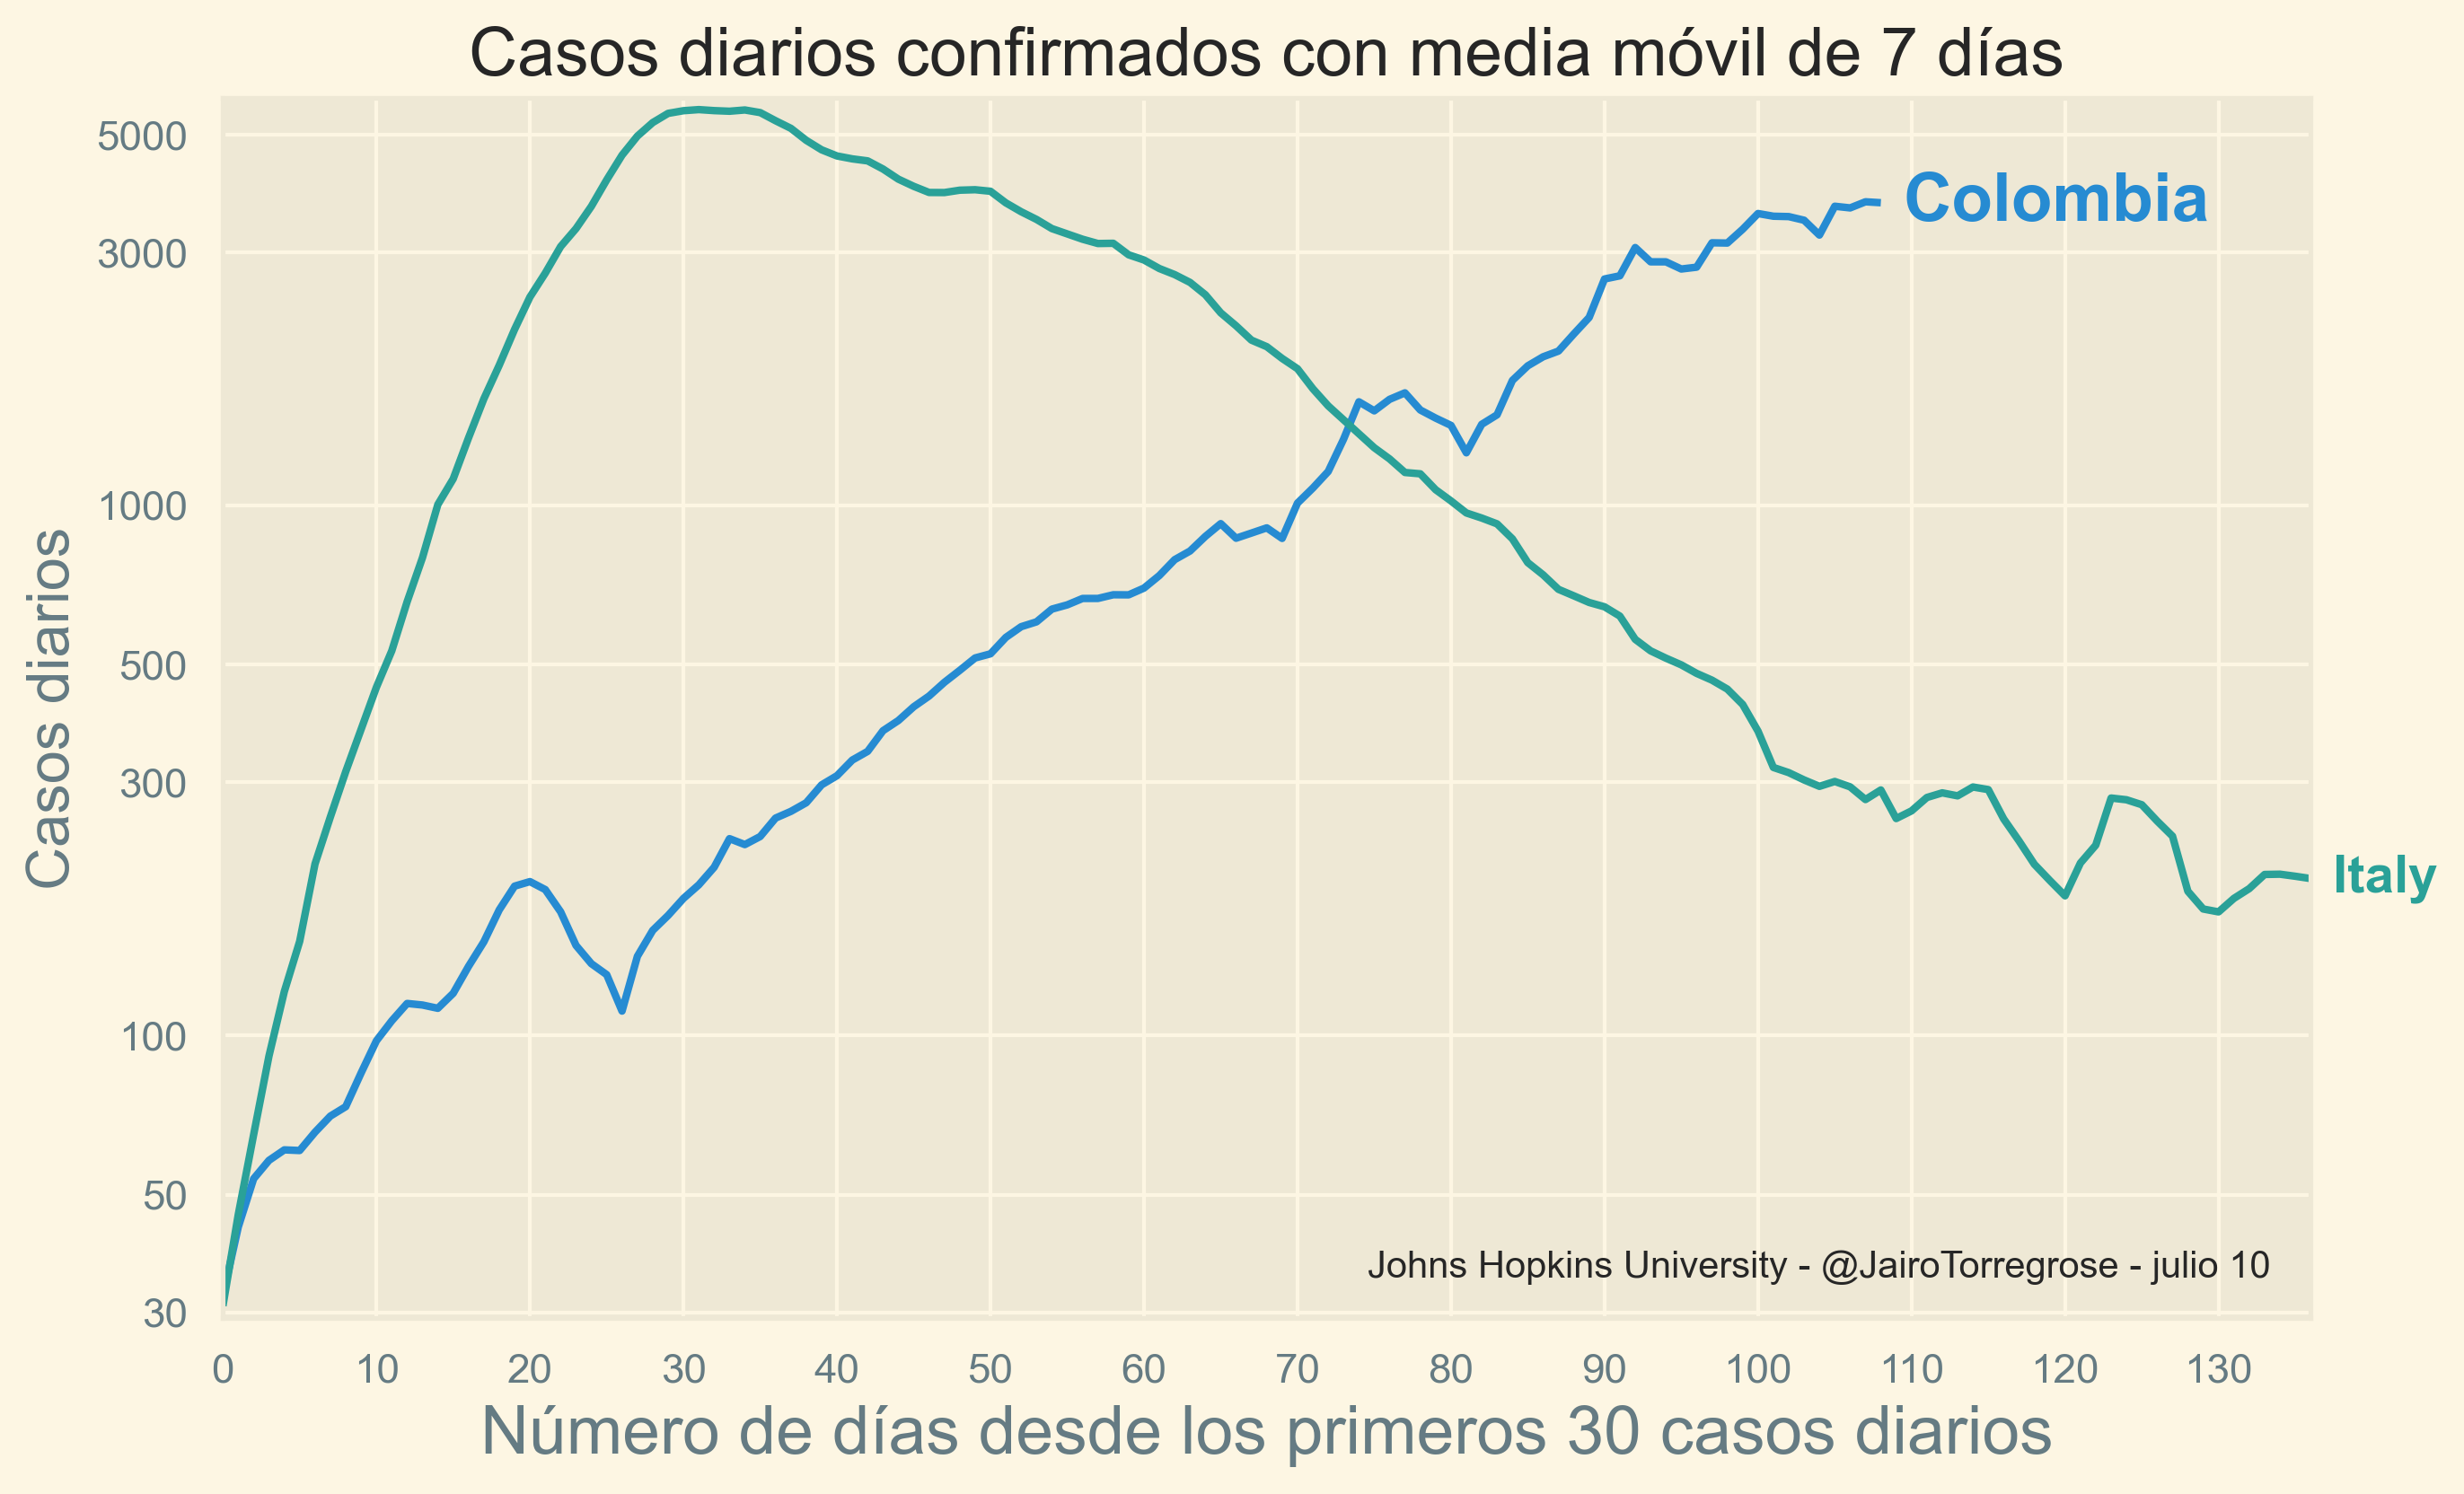

In [16]:
graficar(list_df2, 'mean_new_cases', titulo_casos_diarios, xlabel_casos_diarios, ylabel_casos_diarios)

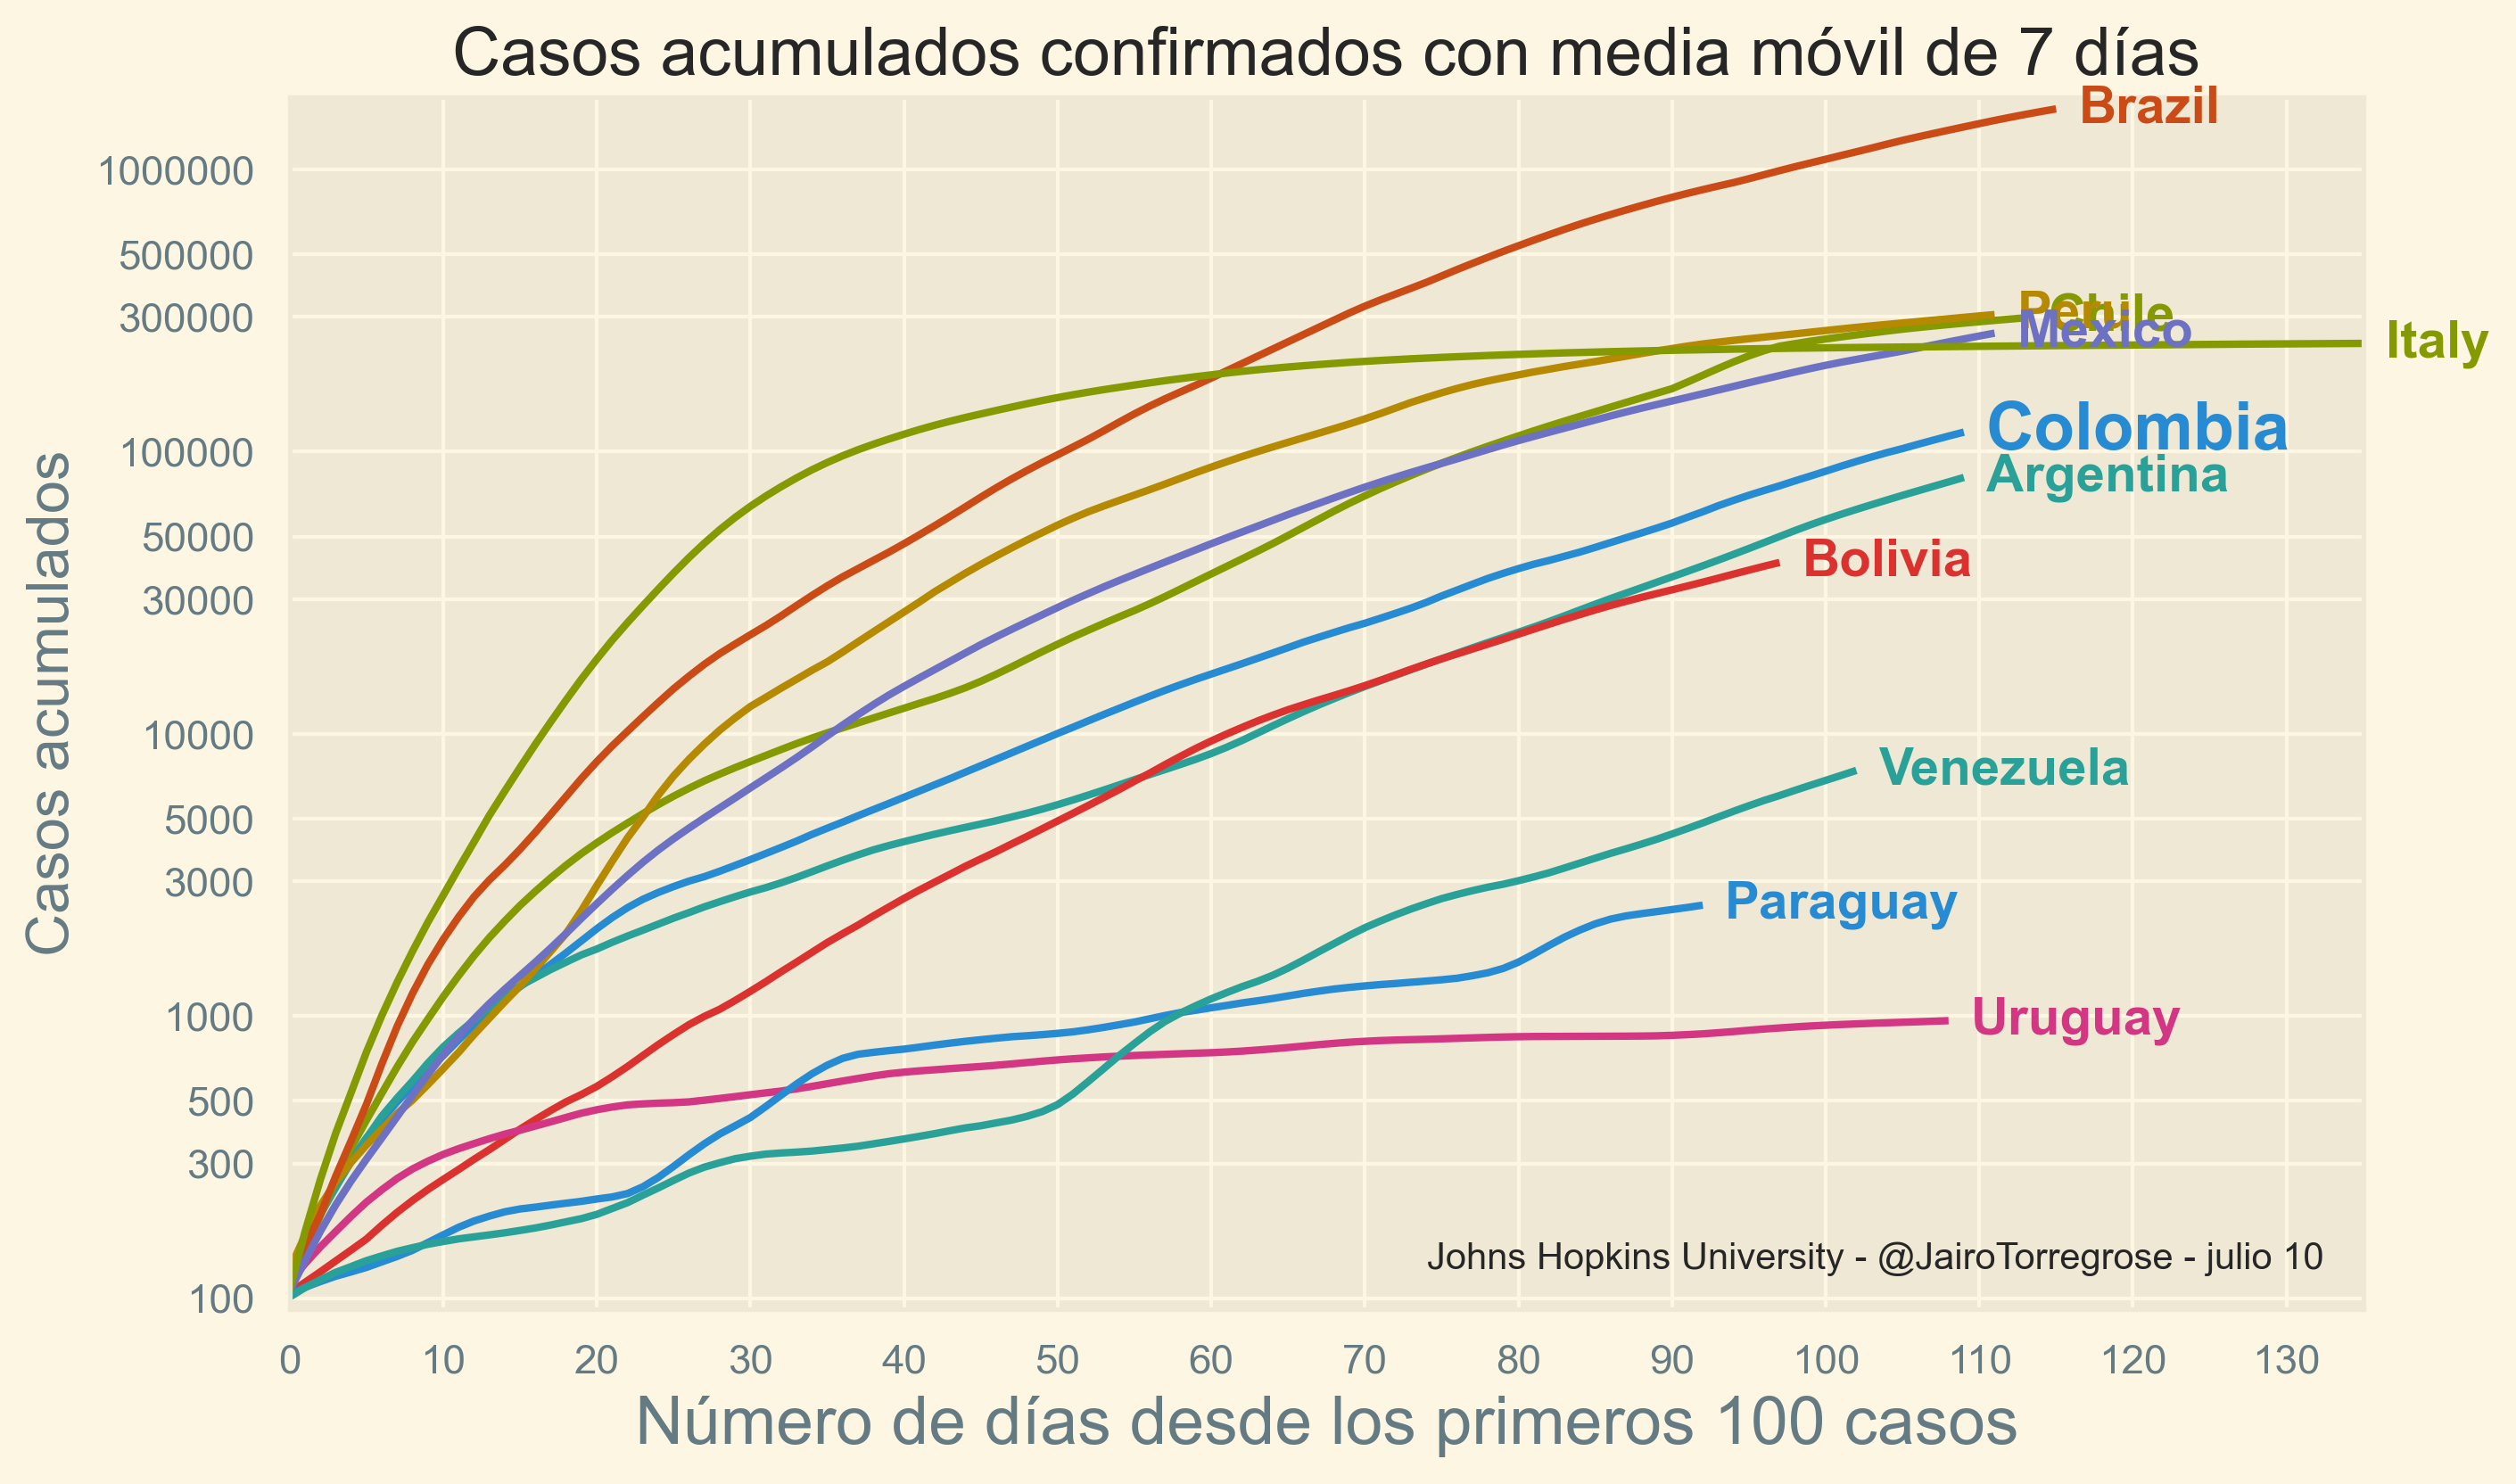

In [17]:
graficar(list_df1, 'mean_cases', titulo_casos_acumulados, xlabel_casos_acumulados, ylabel_casos_acumulados)

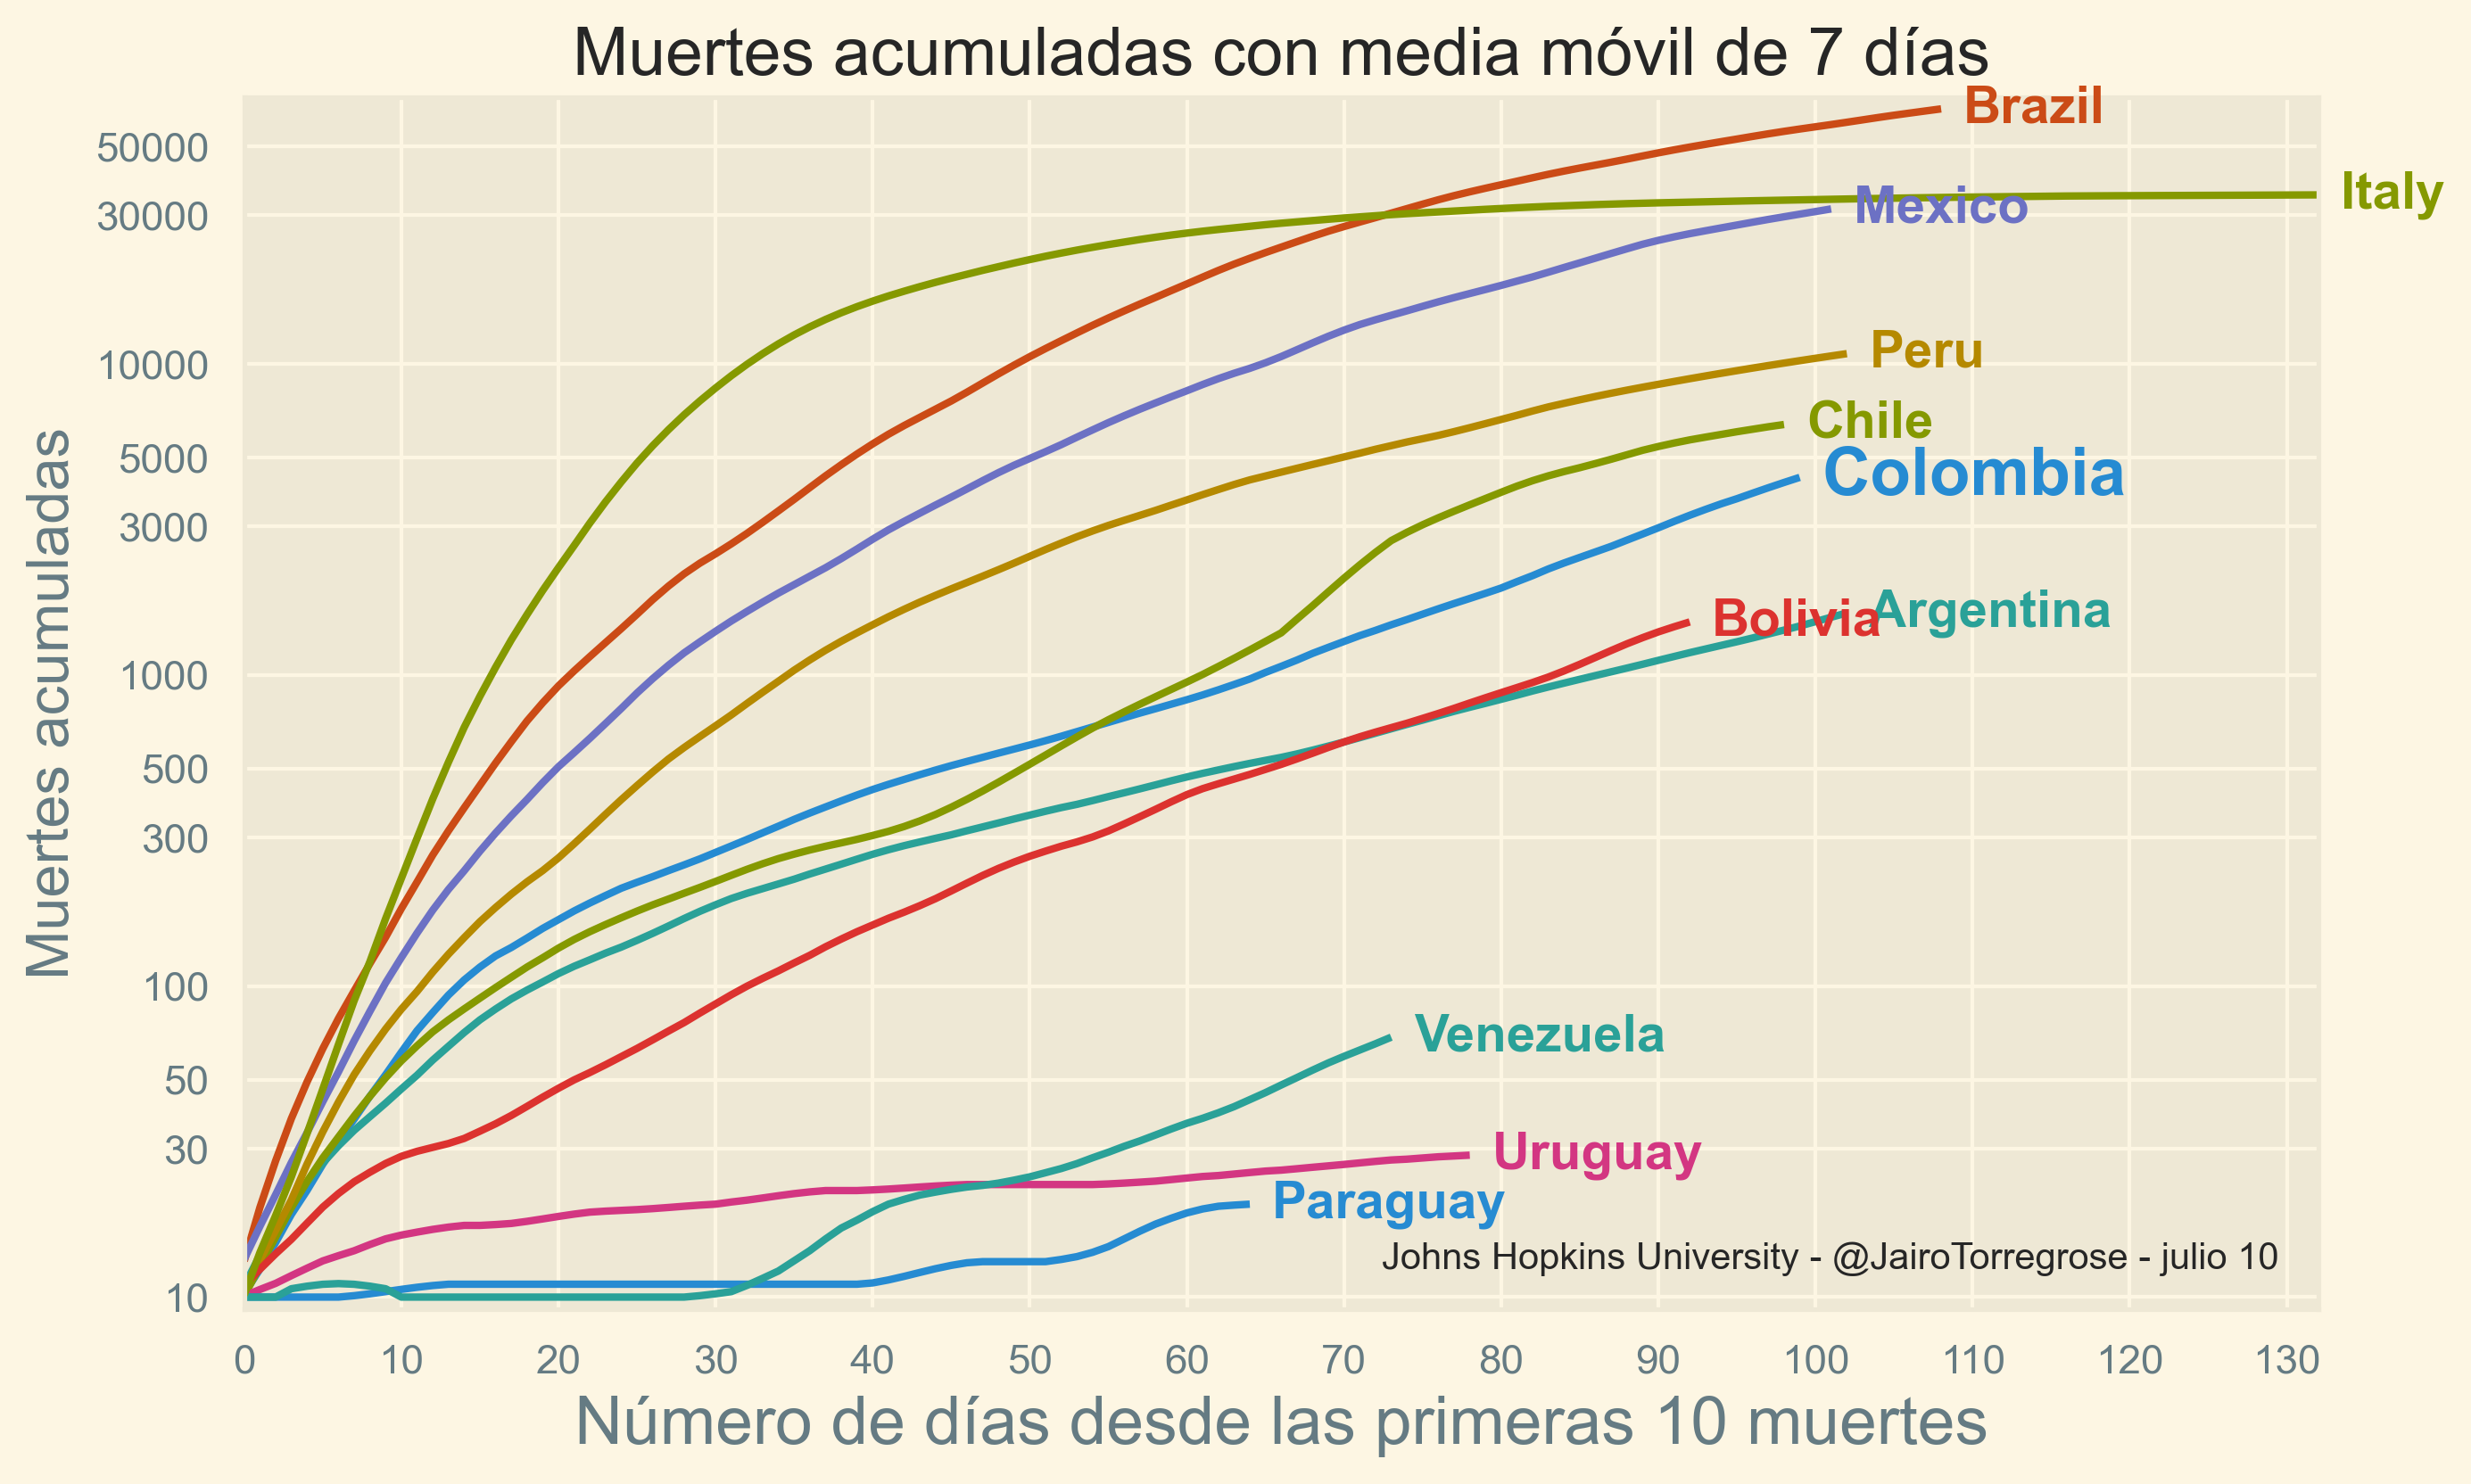

In [18]:
graficar(list_df_deaths, 'mean_deaths', titulo_muertes_acumuladas, xlabel_muertes_acumuladas, ylabel_muertes_acumuladas)

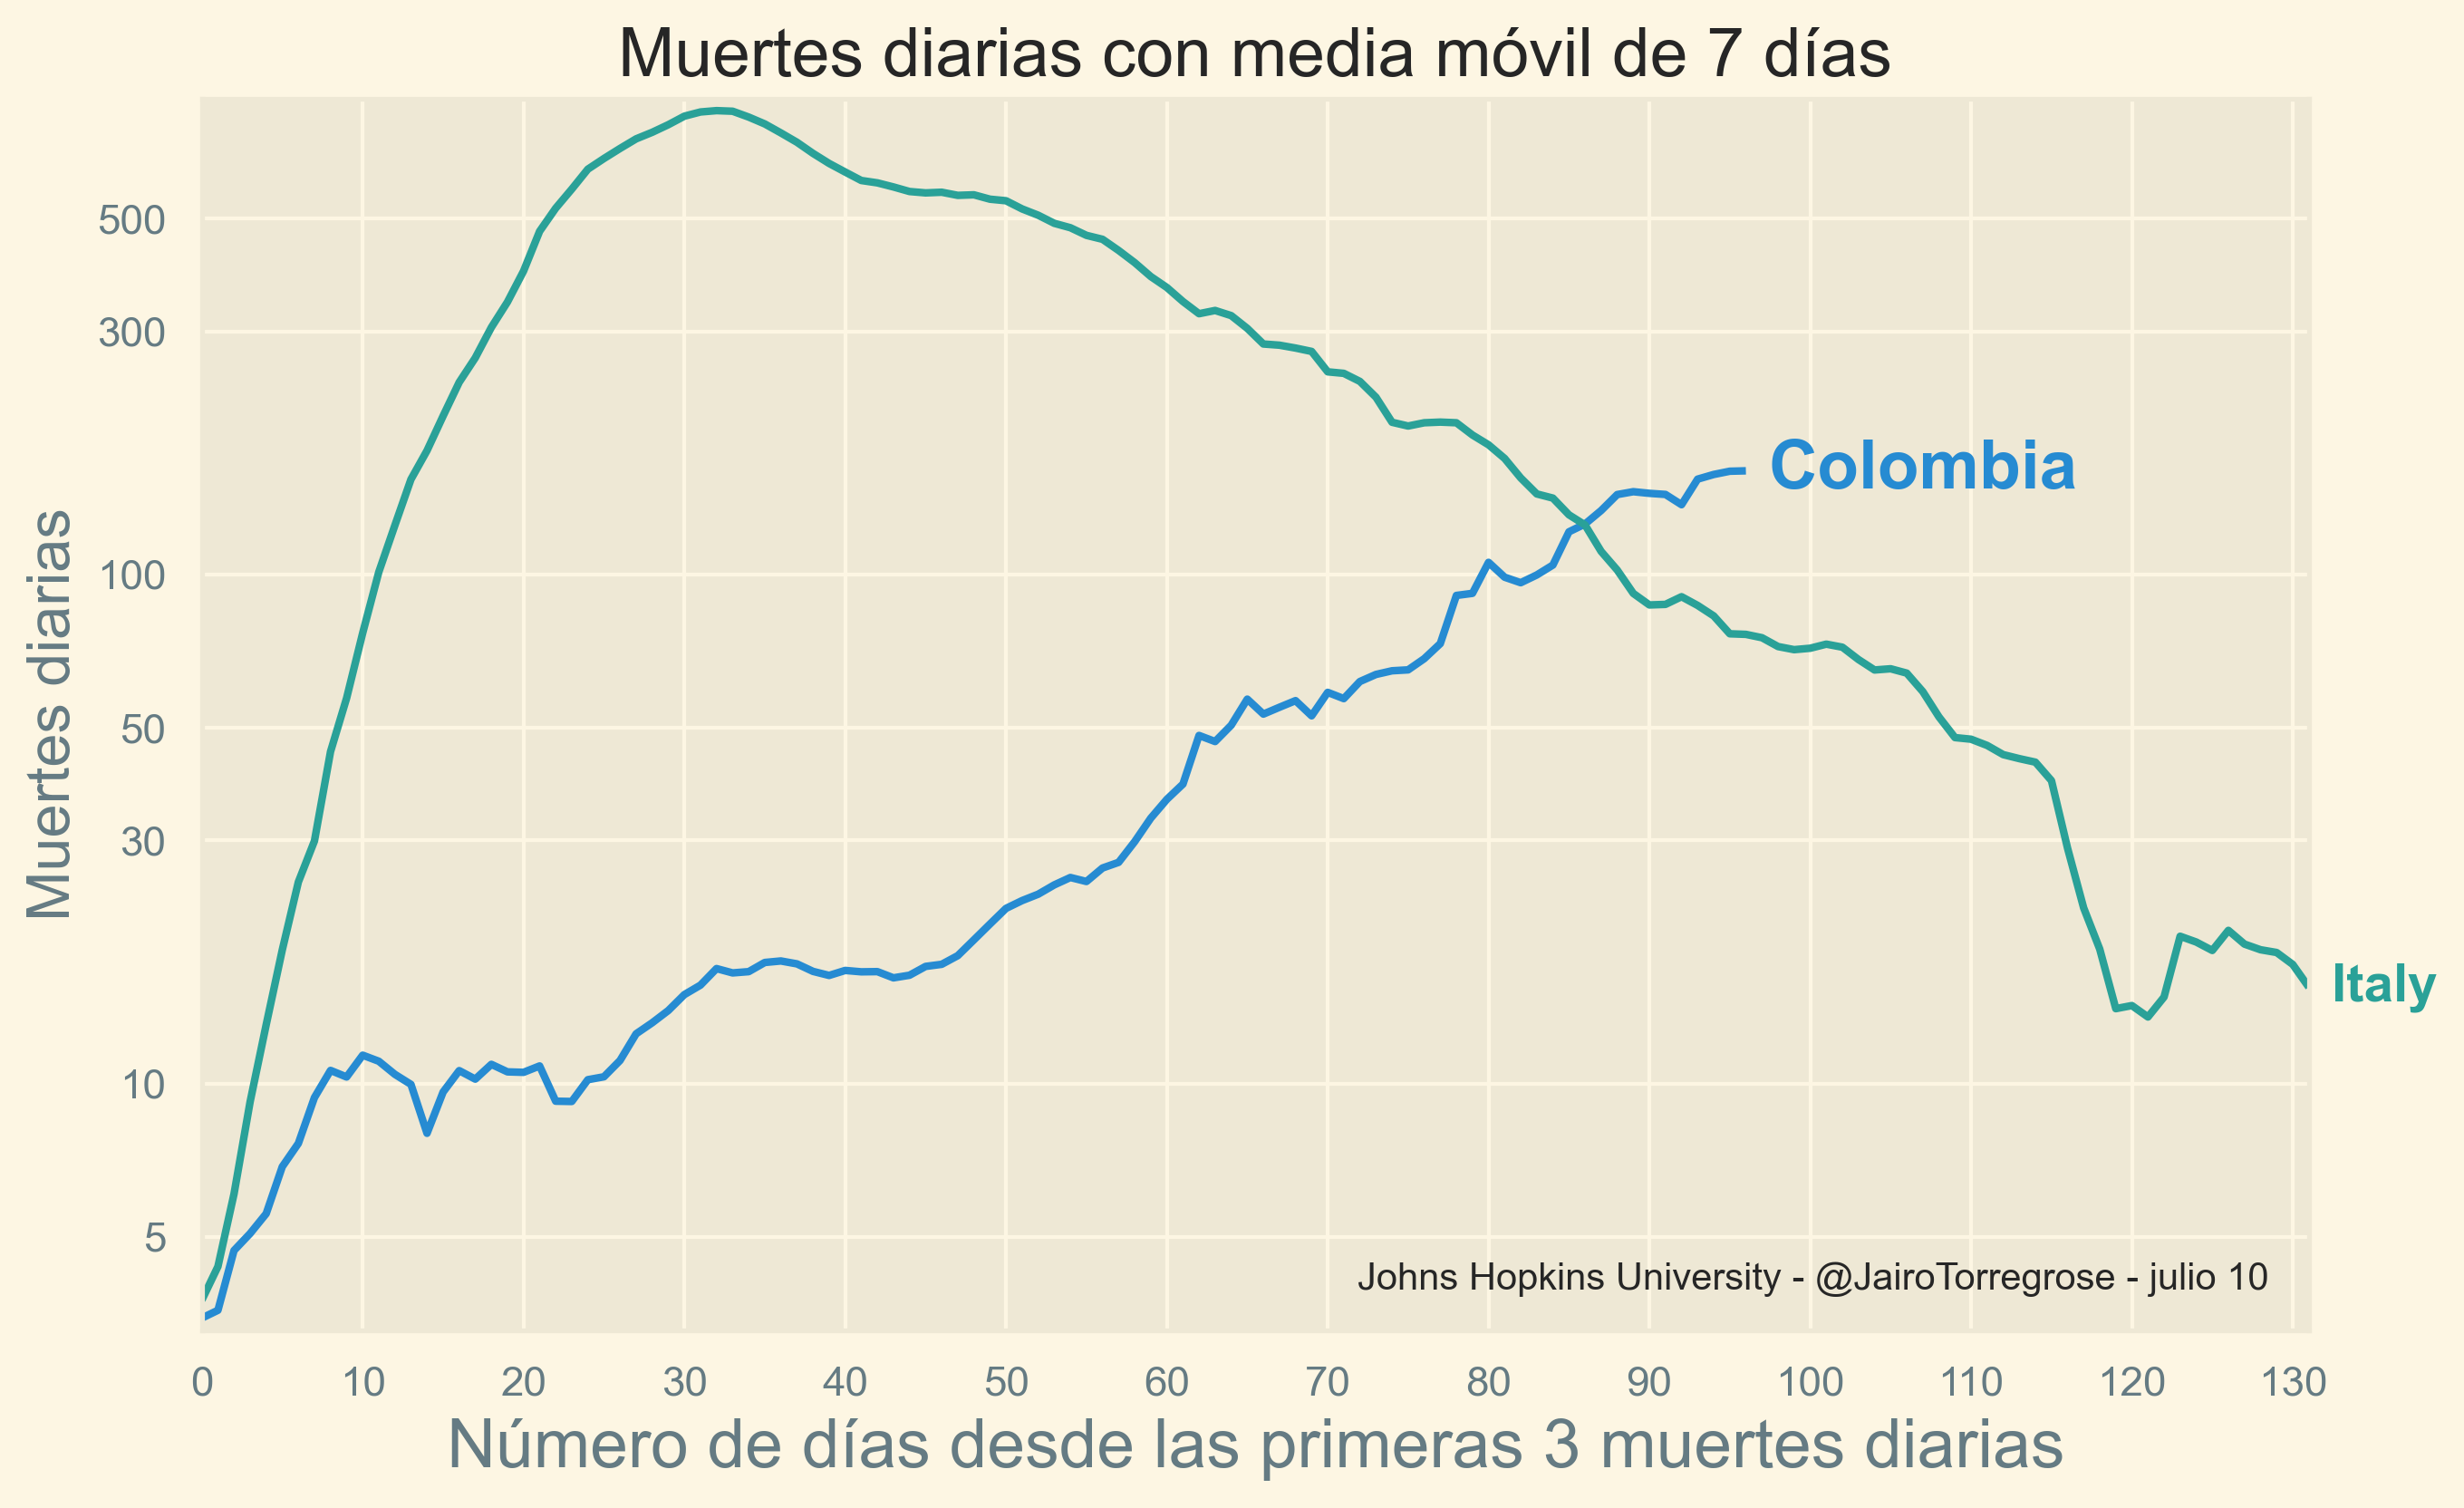

In [19]:
graficar(list_df_daily_deaths, 'mean_daily_deaths', titulo_muertes_diarias, xlabel_muertes_diarias, ylabel_muertes_diarias)

In [20]:
df_daily_deaths_13.tail(20)

,level_0,index,date,casos,casos_nuevos,muertes,muertes_nuevas,recuperados,recuperados_nuevos,activos,muertes %,muertes nuevas %,casos %,casos nuevos %,pais,mean_cases,mean_new_cases,mean_deaths,mean_daily_deaths
103,140,150,2020-06-20,245938,363.0,28322,7.0,150376,0.0,67240,0.02,-99.41,0.15,18.24,Spain,244818.893561,336.880126,27427.497040,166.182876
104,141,151,2020-06-21,246272,334.0,28323,1.0,150376,0.0,67573,0.00,-85.71,0.14,-7.99,Spain,245167.554438,348.660877,27624.028493,196.531453
105,142,152,2020-06-22,246504,232.0,28324,1.0,150376,0.0,67804,0.00,0.00,0.09,-30.54,Spain,245523.120714,355.566276,27832.043622,208.015129
106,143,153,2020-06-23,246752,248.0,28325,1.0,150376,0.0,68051,0.00,0.00,0.10,6.90,Spain,245871.726012,348.605298,28029.125598,197.081976
107,144,154,2020-06-24,247086,334.0,28327,2.0,150376,0.0,68383,0.01,100.00,0.14,34.68,Spain,246204.446904,332.720892,28196.418754,167.293155
108,145,155,2020-06-25,247486,400.0,28330,3.0,150376,0.0,68780,0.01,50.00,0.16,19.76,Spain,246514.530754,310.083850,28323.821456,127.402702
109,146,156,2020-06-26,247905,419.0,28338,8.0,150376,0.0,69191,0.03,166.67,0.17,4.75,Spain,246837.929654,323.398900,28326.649619,2.828163
110,147,157,2020-06-27,248469,564.0,28341,3.0,150376,0.0,69752,0.01,-62.50,0.23,34.61,Spain,247190.675149,352.745495,28329.351226,2.701607
111,148,158,2020-06-28,248770,301.0,28343,2.0,150376,0.0,70051,0.01,-33.33,0.12,-46.63,Spain,247556.188777,365.513628,28332.414798,3.063572
112,149,159,2020-06-29,248970,200.0,28346,3.0,150376,0.0,70248,0.01,50.00,0.08,-33.55,Spain,247926.138052,369.949275,28335.797779,3.382981
